<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 24</font></b></strong>

<strong><b><font size="4">O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br/social

Na aula anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Média Mensal de Vendas. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM.

**Deep Learning - O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning**

Deep Learning é uma tentativa de reproduzir nas máquinas a capacidade de inteligência humana. Logo, se aumentarmos o número de camadas do modelo e aumentarmos o número de neurônios matemáticos, nosso modelo de Deep Learning fica mais "inteligente", ou seja, mais preciso. Certo? Não necessariamente!

Sei que você não quer ouvir isso, mas a verdade precisa ser dita: Tudo depende do seu problema e do seu conjunto de dados!

Para alguns problemas, a simples adição de camadas e/ou neurônios promove um aumento significativo na precisão do modelo. Para outros casos (como o nosso), pode ser um desastre. Por isso, não use o aumento de camadas/neurônios como a sua única estratégia para tentar melhorar a performance de um modelo de Deep Learning.

Vejamos o que acontece quando criamos uma rede realmente profunda!

Esta aula considera algu conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**.

Vamos ao trabalho.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [0]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [0]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [0]:
# É preciso atualizar o Statsmodels
!pip install -q -U statsmodels

     |████████████████████████████████| 8.7MB 9.9MB/s 


In [0]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy           1.18.3
statsmodels     0.11.1
statsmodels.api 0.11.1
pandas          1.0.3
sklearn         0.22.2.post1
seaborn         0.10.0
matplotlib      3.2.1
keras           2.3.1
Data Science Academy


## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [0]:
# Carrega os dados
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [0]:
# Shape
dados.shape

(9994, 21)

In [0]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [0]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [0]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [0]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [0]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [0]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [0]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [0]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [0]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

In [0]:
# Como está ficando o nosso dataset de interesse?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [0]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [0]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

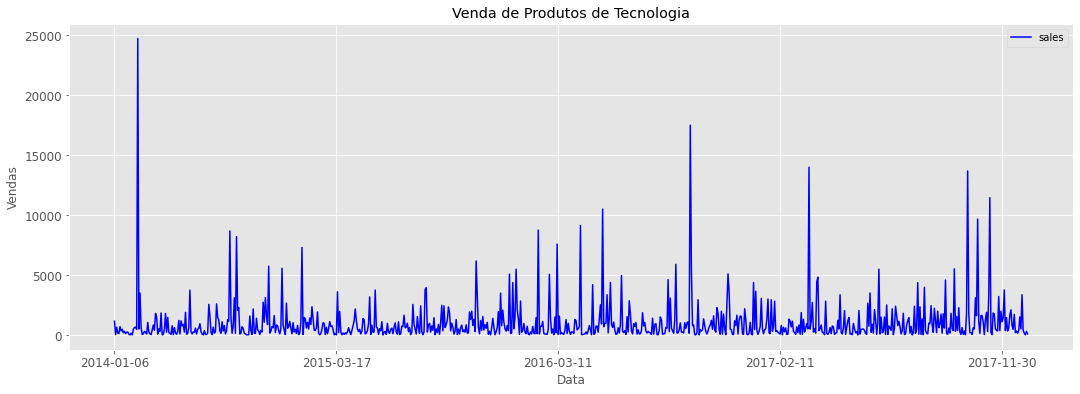

In [0]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [0]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [0]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

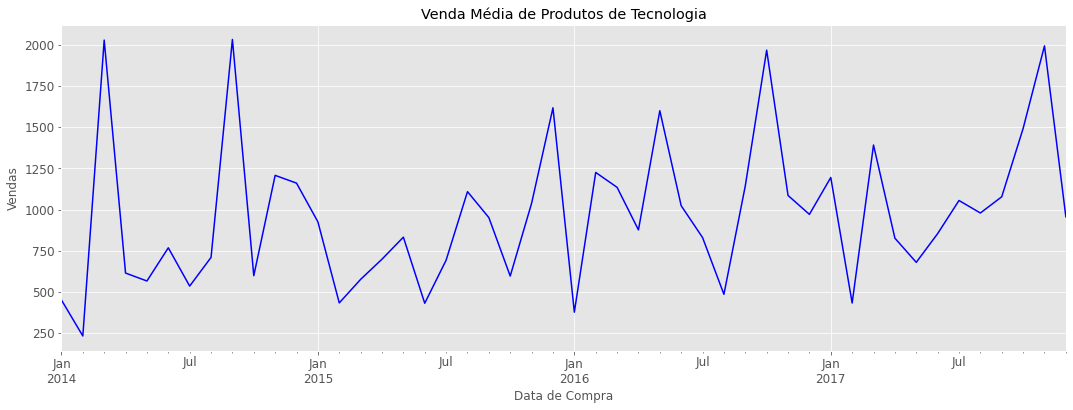

In [0]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

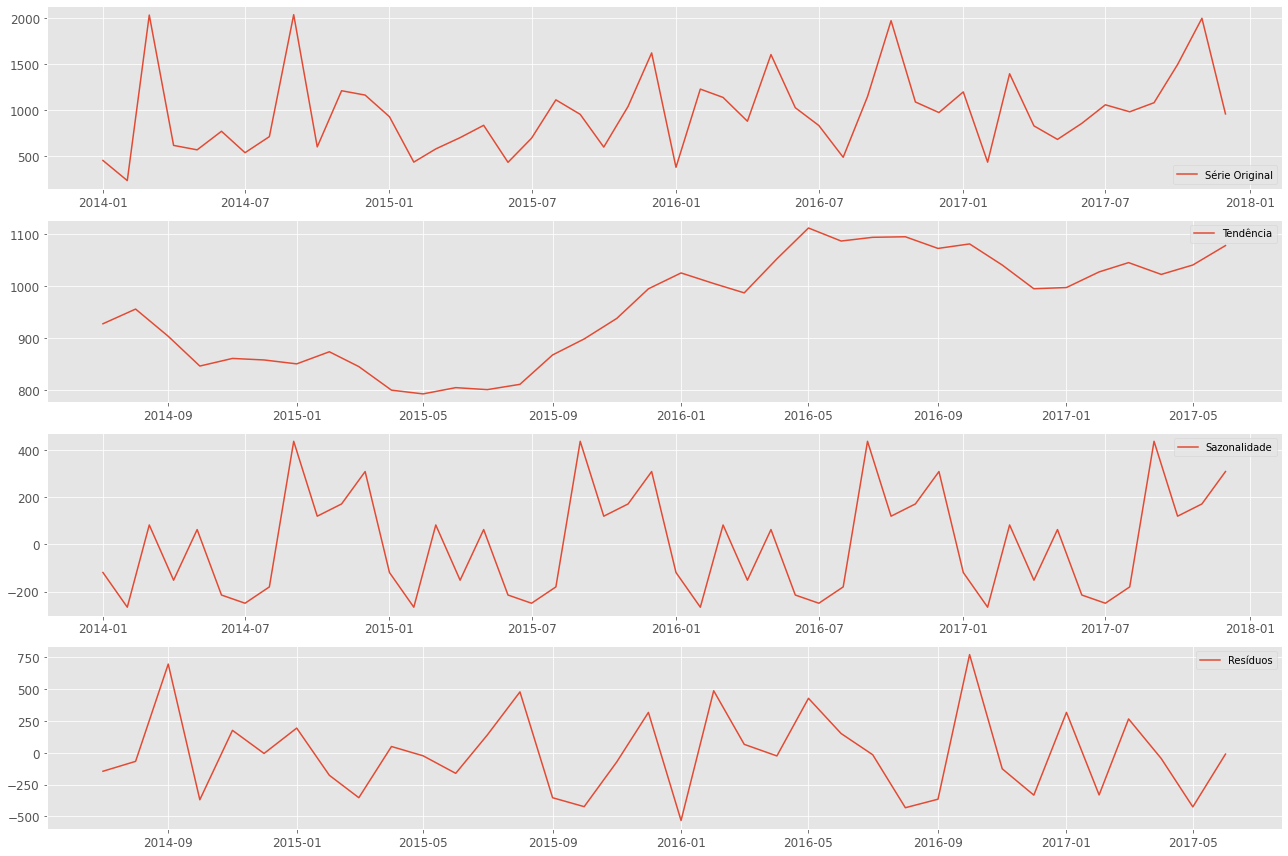

In [0]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [0]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (20, 6))
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

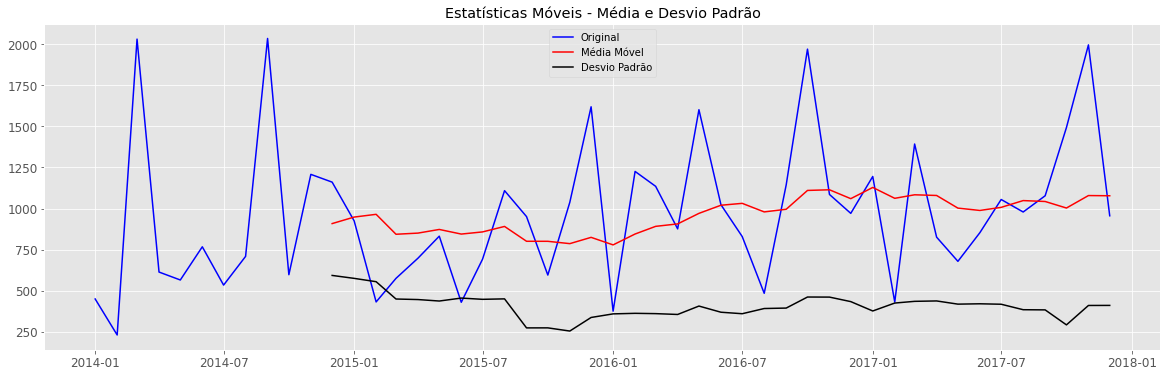


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [0]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Função Para o Cálculo da Acurácia

In [0]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

## O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning

Nesta aula tentaremos aumentar a precisão do nosso modelo aumentando de forma significativa o número de camadas e neurônios.

Execute o modelo e tire suas conclusões.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados.

In [0]:
# Transforma a série temporal em um problema de aprendizagem supervisionada
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

In [0]:
# Cria uma série diferenciada para tornar a série temporal estacionária
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [0]:
# Inverte valor diferenciado
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

In [0]:
# Transforma a série temporal em estacionária
raw_values = media_vendas_tecnologia.values
diff_values = difference(raw_values, 1)

In [0]:
# Transforma a série temporal em aprendizado supervisionado
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [0]:
# Criação do dataset de treino e teste
trainset, testset = supervised_values[0:-12], supervised_values[-12:]

In [0]:
# Normalizamos os dados aplicando scala no intervalo [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = scaler.fit(train)
    
    # Transforma dados de treino
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transforma dados de teste
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [0]:
#  Inverte a escala nas previsões para a escala original
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [0]:
# Transforma a escala dos dados
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [0]:
# Função para o modelo LSTM
def train_lstm(train, nb_epoch):
    
    # Ajusta o shape dos dados
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Modelo
    modelo_lstm = Sequential()
    modelo_lstm.add(LSTM(200, activation = 'relu', return_sequences = True, input_shape = (1, 1)))
    modelo_lstm.add(LSTM(100, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(50, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(25, activation = 'relu'))
    modelo_lstm.add(Dense(20, activation = 'relu'))
    modelo_lstm.add(Dense(10, activation = 'relu'))
    modelo_lstm.add(Dense(1))
    
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

    modelo_lstm.fit(X, y, epochs = nb_epoch, verbose = 1)
    
    return modelo_lstm

> Vamos treinar por 5 mil épocas.

In [0]:
# Treinamento
lstm_model = train_lstm(train_scaled, 5000)

Streaming output truncated to the last 5000 lines.
35/35 [==============================] - 0s 917us/step - loss: 0.1134
Epoch 2502/5000
35/35 [==============================] - 0s 825us/step - loss: 0.1135
Epoch 2503/5000
35/35 [==============================] - 0s 771us/step - loss: 0.1134
Epoch 2504/5000
35/35 [==============================] - 0s 1ms/step - loss: 0.1133
Epoch 2505/5000
35/35 [==============================] - 0s 917us/step - loss: 0.1139
Epoch 2506/5000
35/35 [==============================] - 0s 826us/step - loss: 0.1135
Epoch 2507/5000
35/35 [==============================] - 0s 861us/step - loss: 0.1133
Epoch 2508/5000
35/35 [==============================] - 0s 815us/step - loss: 0.1133
Epoch 2509/5000
35/35 [==============================] - 0s 1ms/step - loss: 0.1133
Epoch 2510/5000
35/35 [==============================] - 0s 792us/step - loss: 0.1132
Epoch 2511/5000
35/35 [==============================] - 0s 873us/step - loss: 0.1132
Epoch 2512/5000
35/35 [

In [0]:
# Forecast em todo o conjunto de dados de treinamento para construir o estado da previsão
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped)

array([[-0.21242124],
       [ 0.06100811],
       [-0.9763454 ],
       [ 0.08983185],
       [-0.17828056],
       [ 0.06721464],
       [ 0.06100935],
       [ 0.07237235],
       [-0.9932556 ],
       [ 0.09017199],
       [-0.15530148],
       [-0.17965814],
       [ 0.06100956],
       [ 0.06105047],
       [-0.11638732],
       [-0.15905339],
       [-0.1509327 ],
       [ 0.06103154],
       [ 0.06199773],
       [ 0.05608039],
       [ 0.06176098],
       [ 0.06102402],
       [ 0.0548833 ],
       [-0.8817562 ],
       [ 0.08619207],
       [-0.42395267],
       [ 0.06857058],
       [ 0.06101186],
       [-0.32409483],
       [ 0.062709  ],
       [ 0.06111801],
       [ 0.06102248],
       [ 0.08226354],
       [-0.40467462],
       [ 0.07154874]], dtype=float32)

In [0]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X)
    return yhat[0,0]

In [0]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões
for i in range(len(test_scaled)):
    
    # Ajusta o shape dos dados de teste
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    
    # Previsão
    yhat = forecast_lstm(lstm_model, X)
    
    # Inverte a escala
    yhat = invert_scale(scaler, X, yhat)
    
    # Inverte a diferenciação
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

Mês = 1, Valor Previsto = 1256.935182, Valor Esperado = 970.554870
Mês = 2, Valor Previsto = 1479.537721, Valor Esperado = 1195.218071
Mês = 3, Valor Previsto = 721.328664, Valor Esperado = 430.501714
Mês = 4, Valor Previsto = 693.077490, Valor Esperado = 1392.859250
Mês = 5, Valor Previsto = 1108.393303, Valor Esperado = 825.559133
Mês = 6, Valor Previsto = 960.601861, Valor Esperado = 678.329400
Mês = 7, Valor Previsto = 1151.980498, Valor Esperado = 853.055000
Mês = 8, Valor Previsto = 1345.615079, Valor Esperado = 1054.996636
Mês = 9, Valor Previsto = 1278.273830, Valor Esperado = 978.842333
Mês = 10, Valor Previsto = 978.789542, Valor Esperado = 1077.704120
Mês = 11, Valor Previsto = 1766.064210, Valor Esperado = 1493.439227
Mês = 12, Valor Previsto = 2250.136161, Valor Esperado = 1996.750920


In [0]:
# Calculamos e imprimos a performance do modelo
dados_teste_original = media_vendas_tecnologia[-12:]
modelo_lstm_performance = performance(dados_teste_original, previsoes_lstm)
modelo_lstm_performance

MSE das previsões é 328890.39
RMSE das previsões é 573.49
MAPE das previsões é 52.98


Observe o que aconteceu. Uma das técnicas de aprendizagem de máquina do planeta agora é o pior modelo que criamos entre todas as versões até aqui. 

E o que deveria ter melhorado a precisão do modelo (mais camadas e mais neurônios) na verdade de mostrou um desastre. Por isso, como profissional, você deve dominar as técnicas do processo e não contar com a apenas uma estratégia. cada problema vai querer uma abordagem diferente.

Vamos finalizar o trabalho como fizemos nas aulas anteriores.

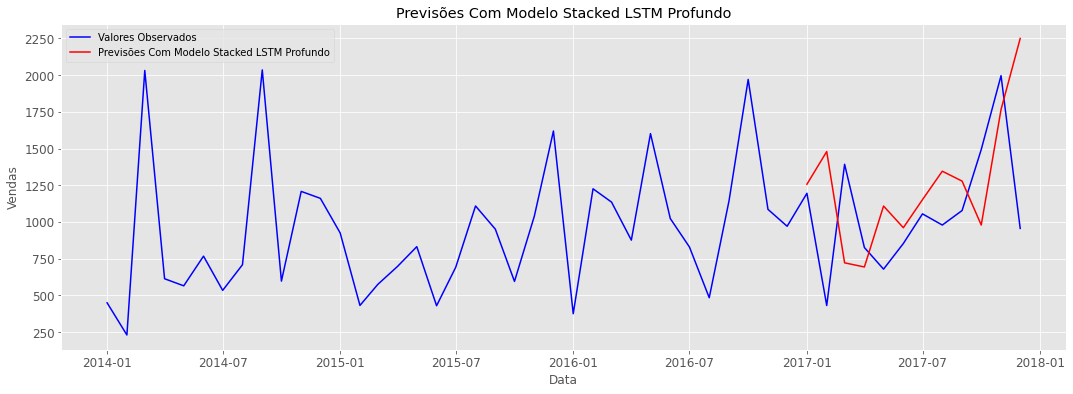

In [0]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(media_vendas_tecnologia.index, 
         media_vendas_tecnologia.values,
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(media_vendas_tecnologia[36:].index, 
         previsoes_lstm,
         label = 'Previsões Com Modelo Stacked LSTM Profundo', 
         color = 'Red')

plt.title('Previsões Com Modelo Stacked LSTM Profundo')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Vamos fazer o Forecasting para 12 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [0]:
# Última data da série
media_vendas_tecnologia.index[-1]

Timestamp('2017-12-01 00:00:00', freq='MS')

In [0]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [media_vendas_tecnologia.index[-1] + DateOffset(months = x) for x in range(0, 13)]

In [0]:
# Visualiza as datas criadas
datas_para_prever_forecasting

[Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00')]

In [0]:
# Nossa série original é um objeto do tipo pd.Series
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(media_vendas_tecnologia)

In [0]:
# Visualiza os dados
df_original.head()

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,2031.948375
2014-04-01,613.028933
2014-05-01,564.698588


In [0]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [0]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,sales
2018-01-01,NaN
2018-02-01,NaN
2018-03-01,NaN
2018-04-01,NaN
2018-05-01,NaN
2018-06-01,NaN
2018-07-01,NaN
2018-08-01,NaN
2018-09-01,NaN
2018-10-01,NaN


In [0]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(previsoes_lstm,
                          index = data_futuras.index, columns = ['Prediction'])

In [0]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [0]:
# Visualiza o dataframe
df_forecasting

,sales,Prediction
2014-01-01,449.041429,NaN
2014-02-01,229.787143,NaN
2014-03-01,2031.948375,NaN
2014-04-01,613.028933,NaN
2014-05-01,564.698588,NaN
2014-06-01,766.905909,NaN
2014-07-01,533.608933,NaN
2014-08-01,708.435385,NaN
2014-09-01,2035.838133,NaN
2014-10-01,596.900900,NaN


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 12 meses que correspondem aos 12 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 12 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

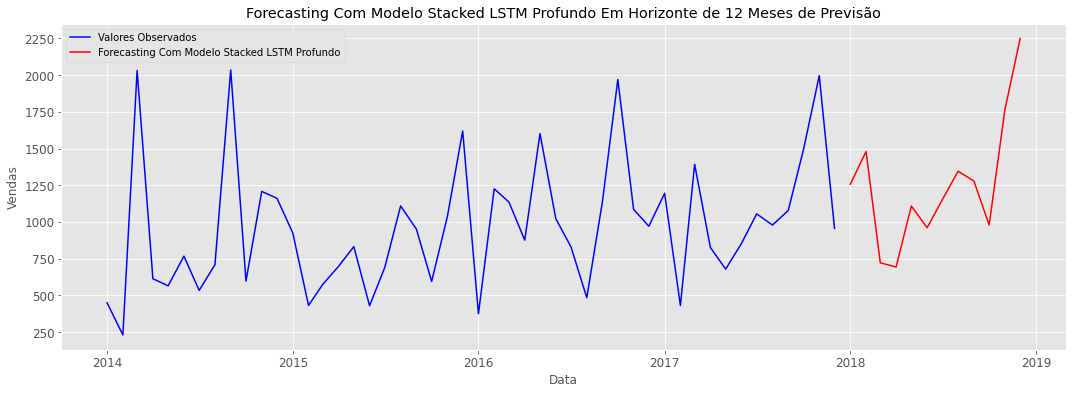

In [0]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(df_forecasting.index, 
         df_forecasting['sales'],
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(df_forecasting.index, 
         df_forecasting['Prediction'],
         label = 'Forecasting Com Modelo Stacked LSTM Profundo', 
         color = 'Red')

plt.title('Forecasting Com Modelo Stacked LSTM Profundo Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Graficamente o resultado não parece tão ruim, mas as métricas demonstram que esse modelo é o pior de todos, ainda possa até mesmo ser usado na falta de outra opção.

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA(1,1) - AIC = 550.3, RMSE = 420.2 e MAPE = 29.58
- Aula 16 --> Modelo ARIMA(6,0,2) - AIC = 559.4, RMSE = 401.5 e MAPE = 26.58
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC = 176.74, RMSE = 425.89 e MAPE = 34.95
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC = 146.77, RMSE = 353.57 e MAPE = 30.55
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66, RMSE = 341.23 e MAPE = 32.54
- Aula 20 --> Modelo Prophet 1 - RMSE = 347.58 e MAPE = 28.53
- Aula 21 --> Modelo Prophet 2 - RMSE = 325.52 e MAPE = 26.45
- Aula 22 --> Modelo LSTM Padrão - RMSE = 397.12 e MAPE = 31.46
- Aula 23 --> Modelo Stacked LSTM - RMSE = 396.24 e MAPE = 36.35
- Aula 24 --> Modelo Stacked LSTM Profundo - RMSE = 504.52 e MAPE = 46.35

Mas.....ainda não fizemos otimização de hiperparâmetros do modelo! Isso é assunto para a próxima aula.

# Fim